# Department of Defense SBIR Awards

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

from mdutils.mdutils import MdUtils
from sklearn.feature_extraction.text import CountVectorizer

# Load Data

In [3]:
# Load data
with open('sbir_ai.json', 'r') as file:
    data = json.load(file)

# Convert to dataframe
df = pd.DataFrame(data)
df.to_csv('SBIR Awards - DoD.csv', index=False)

# Convert formats
df['Award_Amount'] = pd.to_numeric(df.Award_Amount)

# Research Keywords

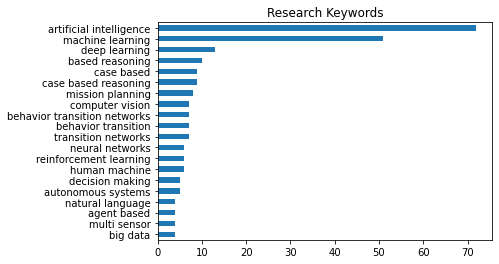

In [4]:
# Extract keywords
research_keywords = df.Research_Keywords.str.split(',').sum()
research_keywords = [re.sub('\(.*\)', '', x) for x in research_keywords]

# Fit CV
cv = CountVectorizer(ngram_range=(2,4))
cv.fit(np.array(research_keywords))

# Convert to dataframe
mat = cv.fit_transform(np.array(research_keywords))
rk = pd.DataFrame(mat.toarray(), columns = cv.get_feature_names())

# Get top 20 keywords
rk.sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot.barh()
plt.title('Research Keywords')
plt.show()

# Titles

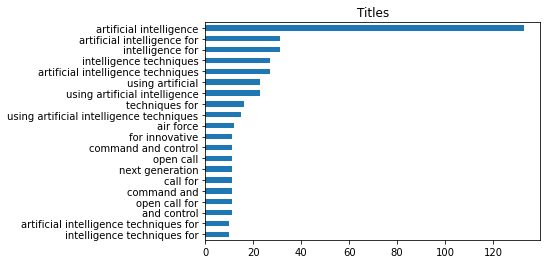

In [5]:
# Extract keywords
titles = df.Award_Title.str.split(',').sum()
titles = [re.sub('\(.*\)', '', x) for x in titles]

# Fit CV
cv = CountVectorizer(ngram_range=(2,4))
cv.fit(np.array(titles))

# Convert to dataframe
mat = cv.fit_transform(np.array(titles))
ttls = pd.DataFrame(mat.toarray(), columns = cv.get_feature_names())

# Get top 20 keywords
ttls.sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot.barh()
plt.title('Titles')
plt.show()

# Abstracts

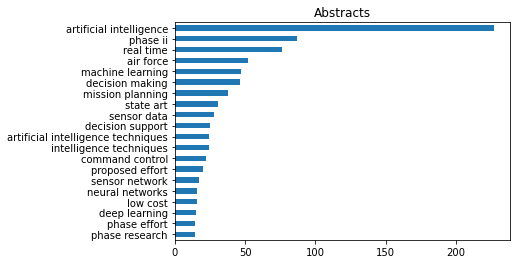

In [6]:
# Extract keywords
abstracts = df.Abstract.str.split(',').sum()
abstracts = [re.sub('\(.*\)', '', x) for x in abstracts]

# Fit CV
cv = CountVectorizer(ngram_range=(2,4), stop_words='english')
cv.fit(np.array(abstracts))

# Convert to dataframe
mat = cv.fit_transform(np.array(abstracts))
abstrx = pd.DataFrame(mat.toarray(), columns = cv.get_feature_names())

# Get top 20 keywords
abstrx.sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot.barh()
plt.title('Abstracts')
plt.show()

# AF, DARPA, MDA

In [7]:
# Filter data and add ID
df_md = df[df.Branch.isin(['Air Force', 'Defense Advanced Research Projects Agency', 'Missile Defense Agency'])]
df_md = df_md.reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
df_md['id'] = df_md['id'] + 1

# Create filename
df_md['filename'] = '[' + df_md['id'].astype(str) + '] ' + df_md.Award_Title.str.title()
df_md['filename'] = df_md['filename'].str.replace('/', ' or ')
df_md['filename'] = df_md['filename'].str.replace(':', ' -')
df_md['filename'] = df_md['filename'].str.replace('\.$', '')
df_md['filename'] = df_md['filename'].str[:150] + '..'

In [ ]:
for i in range(df_md.shape[0]):
    
    # Extract information
    temp_df = df_md.iloc[i]
    filename = temp_df.filename
    title = temp_df.Award_Title.title()
    abstract = temp_df.Abstract
    branch = temp_df.Branch
    award_year = temp_df.Award_Year
    award_amount = temp_df.Award_Amount
    keywords = temp_df.Research_Keywords
    
    # Create files
    mdFile = MdUtils(file_name=f'Reports/{filename}', title=title)
    
    # Abstract
    mdFile.new_header(level=1, title='Abstract')
    mdFile.new_paragraph(abstract)
    mdFile.new_line()
    
    # Award Details
    mdFile.new_header(level=1, title='Award Details')
    temp_tbl = [
        'Branch', 'Award Year', 'Award Amount', 'Keywords', 
        branch, str(award_year), '${:,.0f}'.format(award_amount), keywords.replace(', ', ',').replace(',', ', ')
    ]
    mdFile.new_table(columns=4, rows=2, text=temp_tbl, text_align='center')
    
    # Create file
    mdFile.create_md_file()